# Monte Carlo simulations and weight optimisation on S&P 500 stock portfolios

## Building A Portfolio

We will implement k-means clustering in attempt to diversify our portfolio and group stocks with similar risk-return profiles. We make use of the elbow method and the KneeLocator module to select the optimal number of clusters.

C:\Users\tamea\AppData\Local\Temp\ipykernel_17392\1927285504.py:22: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

[*********************100%***********************]  20 of 20 completed


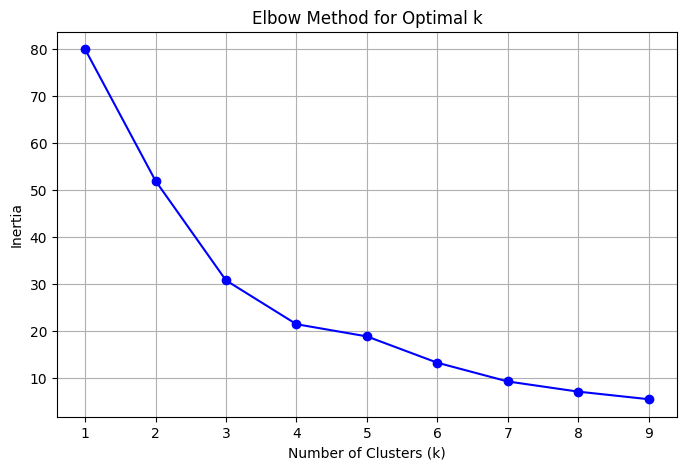

Optimal number of clusters: 4


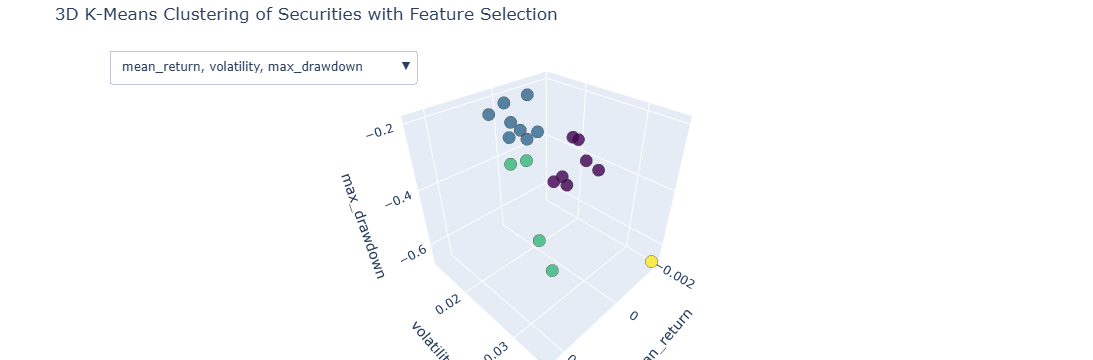


Top Picks from Each Cluster:
              mean_return  volatility  max_drawdown  sharpe_ratio
cluster                                                          
0       CVS     -0.000120    0.025628     -0.383849     -0.170675
        ARES    -0.000164    0.023100     -0.399844     -0.219842
1       LII      0.000582    0.019463     -0.215399      0.347981
        KIM      0.000418    0.014075     -0.234185      0.295575
2       AXON     0.002428    0.033928     -0.300503      1.063329
        UAL      0.001651    0.031816     -0.478194      0.745901
3       TTD     -0.001846    0.034867     -0.668554     -0.911523


In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from kneed import KneeLocator
import requests
random.seed(123)

# Table of S&P 500 tickers from wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})

# Read the table from the page
sp500_table = pd.read_html(response.text, flavor='lxml')[0]
sp500_tickers = sp500_table['Symbol'].tolist()

# Select a random sample from the S&P 500 stocks
tickers = random.sample(sp500_tickers, 20)

# Download adjusted closing prices
data = yf.download(tickers, start="2024-04-06", end="2025-04-05", auto_adjust=True)['Close']
returns = data.pct_change()

# Function to calculate max drawdown
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

# Risk-free rate
risk_free_rate = np.exp(np.log(0.04 + 1)/252) - 1

# Feature engineering: use mean return and volatility
features = pd.DataFrame(index=tickers)
features['mean_return'] = returns.mean()
features['volatility'] = returns.std()
features['max_drawdown'] = returns.apply(max_drawdown)
features['sharpe_ratio'] = (features['mean_return'] - risk_free_rate)*np.sqrt(252) / features['volatility']

# Normalise the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow method to calcuate the inertia for different numbers of clusters k
inertia = []
k_range = range(1, 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

# Plot Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Based on elbow, select optimal k and from clusters
kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.knee
print(f"Optimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled_features)

# 3D INTERACTIVE PLOTLY PLOT

# Define all combinations of 3 out of 4 features
all_features = ['mean_return', 'volatility', 'max_drawdown', 'sharpe_ratio']
feature_combos = list(combinations(all_features, 3))

# Prepare traces for each feature combo
fig = go.Figure()

for i, (x, y, z) in enumerate(feature_combos):
    visible = True if i == 0 else False
    fig.add_trace(go.Scatter3d(
        x=features[x],
        y=features[y],
        z=features[z],
        mode='markers',
        text=features.index,
        marker=dict(
            size=7,
            color=features['cluster'],
            colorscale='viridis',
            opacity=0.8,
            line=dict(width=1)
        ),
        name=f"{x}, {y}, {z}",
        visible=visible
    ))

# Dropdown menu for selecting features
dropdown_buttons = []

for i, (x, y, z) in enumerate(feature_combos):
    visibility = [j == i for j in range(len(feature_combos))]
    label = f"{x}, {y}, {z}"
    dropdown_buttons.append(dict(
        label=label,
        method='update',
        args=[{'visible': visibility},
              {'scene': dict(
                  xaxis_title=x,
                  yaxis_title=y,
                  zaxis_title=z
              )}]
    ))

# Layout
fig.update_layout(
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.0,
        yanchor="top"
    )],
    scene=dict(
        xaxis_title=feature_combos[0][0],
        yaxis_title=feature_combos[0][1],
        zaxis_title=feature_combos[0][2],
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    title="3D K-Means Clustering of Securities with Feature Selection"
)

fig.show()

# Select 2 securities per cluster
top_picks = features.groupby('cluster').apply(lambda df: df.sort_values('sharpe_ratio', ascending=False).head(2), include_groups=False)
print("\nTop Picks from Each Cluster:")
print(top_picks)

## Monte Carlo Simulations

Using top picks from each cluster we will form a portfolio of uniform weighting. Under the assumptions that daily returns are normally distributed we can simulate the price path of the portfolio using a multivariate normal distrubtion.


Selected Securities from Clusters:
['CVS', 'ARES', 'LII', 'KIM', 'AXON', 'UAL', 'TTD']


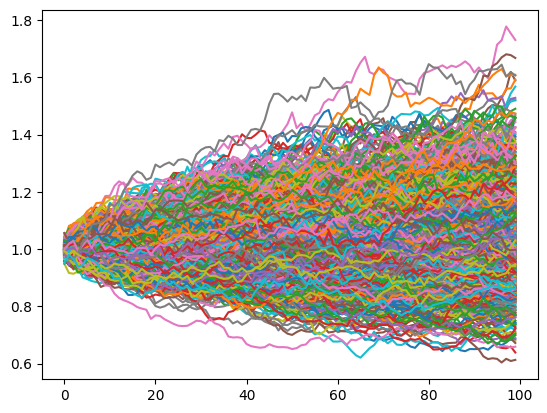

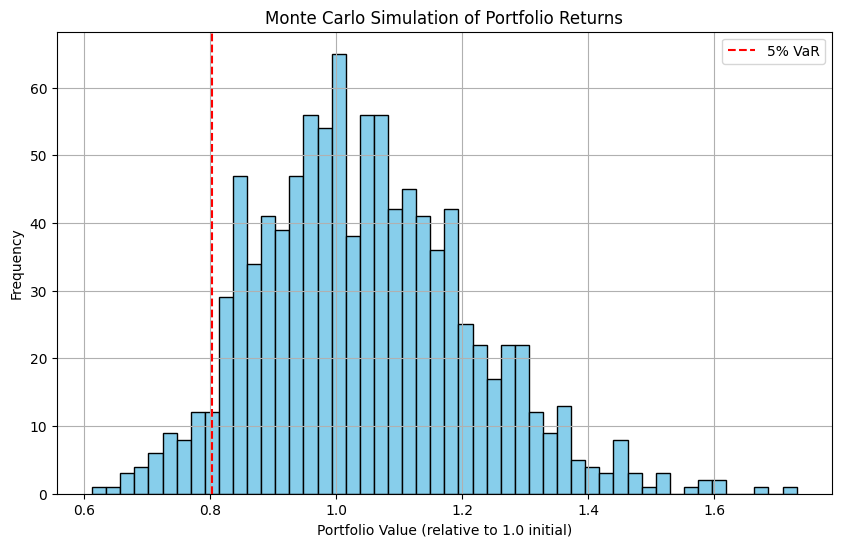


Monte Carlo Portfolio Performance
Mean Return: 4.63%
Std Dev of Return: 16.88%
Value at Risk (5%): 19.73%
Conditional VaR (5%): 25.60%
Mean Max Drawdown: -14.87%


In [56]:
np.random.seed(123)
# Select top picks
top_picks = features.groupby('cluster').apply(lambda df: df.sort_values('sharpe_ratio', ascending=False).head(2), include_groups=False)
top_picks.index = top_picks.index.droplevel(0)  # Drop cluster number from multiindex
selected_tickers = top_picks.index.tolist()
print(f"\nSelected Securities from Clusters:\n{selected_tickers}")

# MONTE CARLO SIMULATION (with uniform weights)

n_simulations = 1000
n_days = 100

# Use historical mean & cov for selected tickers
selected_returns = returns[selected_tickers]
mean_returns = selected_returns.mean().values
cov_matrix = selected_returns.cov().values
weights = np.array([1/len(selected_tickers)] * len(selected_tickers))  # Equal weighting

# Simulate future price paths
meanM = np.full(shape=(n_days, len(weights)), fill_value=mean_returns)
meanM = meanM.T

portfolio_sims = np.full(shape=(n_days, n_simulations), fill_value=0.0)

for i in range(n_simulations):
    Z = np.random.normal(size=(n_days, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = meanM + np.inner(L, Z)
    portfolio_sims[:,i] = np.cumprod(np.inner(weights, daily_returns.T)+1) * 1.0

mdd = pd.DataFrame(portfolio_sims).pct_change().apply(max_drawdown)

# Plots for price paths and histogram of final porfolio values
plt.plot(portfolio_sims)
plt.show()

portfolio_results = portfolio_sims[-1,:] 

plt.figure(figsize=(10, 6))
plt.hist(portfolio_results, bins=50, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(portfolio_results, 5), color='red', linestyle='dashed', label='5% VaR')
plt.title('Monte Carlo Simulation of Portfolio Returns')
plt.xlabel('Portfolio Value (relative to 1.0 initial)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Metrics
mean_sim_return = np.mean(portfolio_results) - 1
std_sim_return = np.std(portfolio_results)
var_95 = 1 - np.percentile(portfolio_results, 5)
cvar_95 = 1 - portfolio_results[portfolio_results < np.percentile(portfolio_results, 5)].mean()
mean_mdd = mdd.mean()

print(f"\nMonte Carlo Portfolio Performance")
print(f"Mean Return: {mean_sim_return:.2%}")
print(f"Std Dev of Return: {std_sim_return:.2%}")
print(f"Value at Risk (5%): {var_95:.2%}")
print(f"Conditional VaR (5%): {cvar_95:.2%}")
print(f"Mean Max Drawdown: {mean_mdd:.2%}")

We can then optimise the weighting of the portfolio for the Sharpe ratio to explore the effects this has on the perfomance.

In [57]:
# Define portfolio metrics
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate)*np.sqrt(252) / port_volatility
    return port_return, port_volatility, sharpe_ratio

# Objective: minimise negative Sharpe (to maximize Sharpe)
def neg_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: no short-selling (0 ≤ w ≤ 1)
bounds = tuple((0, 1) for i in range(len(selected_tickers)))

# Initial guess: equal weights
initial_weights = np.array([1/len(selected_tickers)] * len(selected_tickers))

# Optimise
opt_result = minimize(
    neg_sharpe,
    initial_weights,
    args=(mean_returns, cov_matrix, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Optimised weights
opt_weights = opt_result.x
print("\n Optimized Weights (Max Sharpe):")
for ticker, weight in zip(selected_tickers, opt_weights):
    print(f"{ticker}: {weight:.2%}")


 Optimized Weights (Max Sharpe):
CVS: 0.00%
ARES: 0.00%
LII: 0.00%
KIM: 2.15%
AXON: 61.75%
UAL: 36.10%
TTD: 0.00%


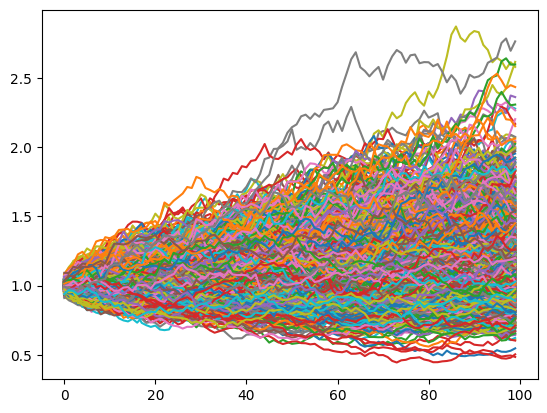

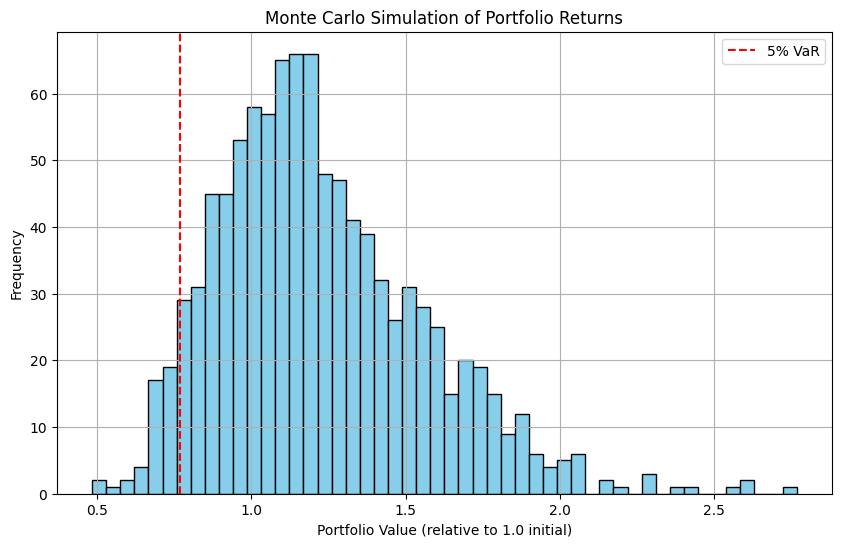


Monte Carlo Portfolio Performance:
Mean Return: 22.48%
Std Dev of Return: 33.30%
Value at Risk (5%): 23.26%
Conditional VaR (5%): 30.26%
Mean Max Drawdown: -21.01%


In [58]:
# MONTE CARLO SIMULATION (with weights optimised for Sharpe ratio)
np.random.seed(123)
weights = opt_weights

portfolio_sims = np.full(shape=(n_days, n_simulations), fill_value=0.0)

for i in range(n_simulations):
    Z = np.random.normal(size=(n_days, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = meanM + np.inner(L, Z)
    portfolio_sims[:,i] = np.cumprod(np.inner(weights, daily_returns.T)+1) * 1.0

mdd = pd.DataFrame(portfolio_sims).pct_change().apply(max_drawdown)

# Plots
plt.plot(portfolio_sims)
plt.show()

portfolio_results = portfolio_sims[-1,:]

plt.figure(figsize=(10, 6))
plt.hist(portfolio_results, bins=50, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(portfolio_results, 5), color='red', linestyle='dashed', label='5% VaR')
plt.title('Monte Carlo Simulation of Portfolio Returns')
plt.xlabel('Portfolio Value (relative to 1.0 initial)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Metrics
mean_sim_return = np.mean(portfolio_results) - 1
std_sim_return = np.std(portfolio_results)
var_95 = 1 - np.percentile(portfolio_results, 5)
cvar_95 = 1 - portfolio_results[portfolio_results < np.percentile(portfolio_results, 5)].mean()
mean_mdd = mdd.mean()

print(f"\nMonte Carlo Portfolio Performance:")
print(f"Mean Return: {mean_sim_return:.2%}")
print(f"Std Dev of Return: {std_sim_return:.2%}")
print(f"Value at Risk (5%): {var_95:.2%}")
print(f"Conditional VaR (5%): {cvar_95:.2%}")
print(f"Mean Max Drawdown: {mean_mdd:.2%}")

## Efficient Frontier

There are also other weightings that may be useful to consider for minmimising risk or accruing expected returns above a specified threshold with minimal risk. To find such weightings we plot an efficient frontier.

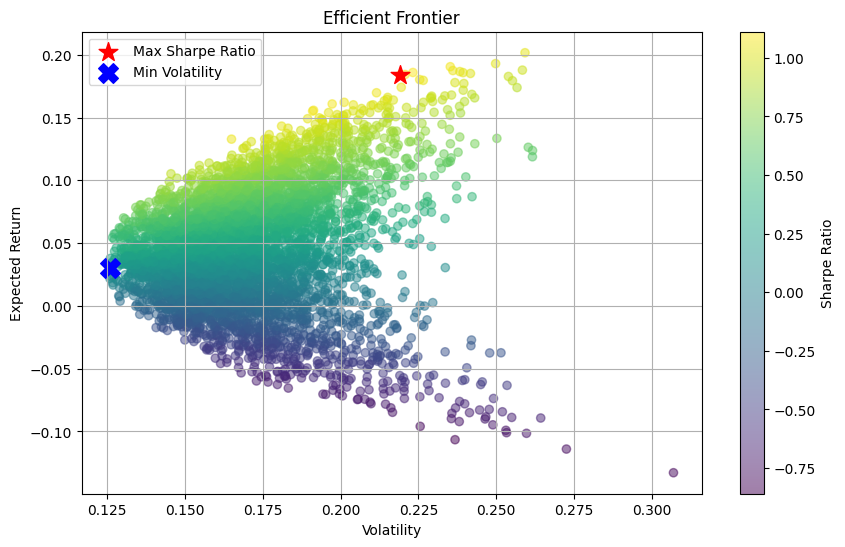


 Optimized Weights (Min Volatility):
CVS: 7.85%
ARES: 2.60%
LII: 10.89%
KIM: 61.90%
AXON: 4.76%
UAL: 2.74%
TTD: 9.25%

 Weights that return at least 10% with the least risk:
CVS: 3.14%
ARES: 2.94%
LII: 5.51%
KIM: 52.92%
AXON: 23.21%
UAL: 12.00%
TTD: 0.27%


In [60]:
# EFFICIENT FRONTIER
np.random.seed(123)
# Settings
n_portfolios = 5000

results = {
    "returns": [],
    "volatility": [],
    "sharpe": [],
    "weights": []
}

for i in range(n_portfolios):
    weights = np.random.dirichlet(np.ones(len(selected_tickers)))
    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate)*np.sqrt(252) / port_volatility

    # Annualise (or convert to relevant period i.e. 100 days)
    port_return = ((1 + port_return)**100) - 1
    port_volatility =  port_volatility * np.sqrt(100)

    results["returns"].append(port_return)
    results["volatility"].append(port_volatility)
    results["sharpe"].append(sharpe_ratio)
    results["weights"].append(weights)

# Convert to DataFrame
portfolios_df = pd.DataFrame(results)

# Find max Sharpe and min volatility
max_sharpe_idx = portfolios_df['sharpe'].idxmax()
min_vol_idx = portfolios_df['volatility'].idxmin()

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    portfolios_df['volatility'],
    portfolios_df['returns'],
    c=portfolios_df['sharpe'],
    cmap='viridis',
    alpha=0.5
)
plt.colorbar(scatter, label='Sharpe Ratio')

# Highlight special points
plt.scatter(
    portfolios_df.loc[max_sharpe_idx, 'volatility'],
    portfolios_df.loc[max_sharpe_idx, 'returns'],
    c='red', marker='*', s=200, label='Max Sharpe Ratio'
)

plt.scatter(
    portfolios_df.loc[min_vol_idx, 'volatility'],
    portfolios_df.loc[min_vol_idx, 'returns'],
    c='blue', marker='X', s=200, label='Min Volatility'
)

plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

# Show weights optimised for min volatility
print("\n Optimized Weights (Min Volatility):")
for ticker, weight in zip(selected_tickers, portfolios_df.loc[min_vol_idx, 'weights']):
    print(f"{ticker}: {weight:.2%}")

# Weights that returns at least 10% with least risk
return_min_vol_idx = portfolios_df[portfolios_df['returns']>=0.1]['volatility'].idxmin()
print("\n Weights that return at least 10% with the least risk:")
for ticker, weight in zip(selected_tickers, portfolios_df.loc[return_min_vol_idx, 'weights']):
    print(f"{ticker}: {weight:.2%}")

We may run Monte Carlo simulations applying these weightings to see how performance differs to the Sharpe ratio optimised weightings.